In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from cryptography.hazmat.primitives.ciphers import (
    Cipher, algorithms, modes
)
from cryptography.hazmat.primitives.asymmetric import rsa , padding , utils
from cryptography.hazmat.primitives import serialization , hashes
from cryptography.hazmat.backends import default_backend

In [2]:
def show_pic(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    ax.imshow(img)
#     plt.title(name)

In [3]:
def load_img(imgPath):
    img = cv2.imread(imgPath)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [4]:
def load_show_img(imgPath):
    img = load_img(imgPath)
    show_pic(img)
    return img

In [5]:
def read_file(fileName):
    file = open(fileName, "r")
    message = file.read()
    file.close()
    return message

In [6]:
def write_file(fileName, message):
    file = open(fileName, "w")
    file.write(message)
    file.close()

In [7]:
def pixel2binary(pixel):
    
  if type(pixel) == bytes or type(pixel) == np.ndarray:
    result= [ format(i, "08b") for i in pixel ]
    
  else:
    raise TypeError("Input type is not supported")
    
  return result  

In [8]:
def cipher2binary(message):
    
  if type(message) == bytes:
    result= ''.join([ format(i, "08b") for i in message ])

  else:
    raise TypeError("Input type is not supported")
    
  return result  

# Cover image for steganography

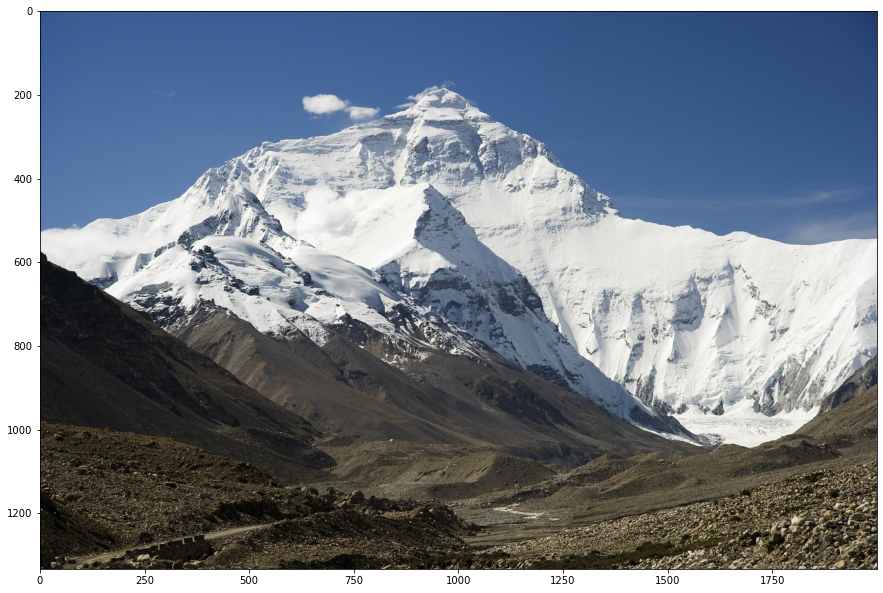

In [9]:
imgFileName = 'content/mountain.jpg'
img = load_show_img(imgFileName)

# Steganography encoder & decoder functions

In [10]:
def encode_data_to_img(imgFileName, data):
    
    list1=[ ]
    
    if (len(data) == 0): 
      raise ValueError('Data is empty')
  
#     filename = input("Enter the name of the New Image after Encoding(without extension):")
#     filename += '.png'
    
    img = load_img(imgFileName)
    no_bytes=(img.shape[0] * img.shape[1] * 3) // 8
    
    print("Maximum bytes to encode:", no_bytes-3)
    
    
#     # Using the below as delimeter
    delim = b'***'
    data+=delim
    
    if(len(data)>no_bytes):
        raise ValueError("Error encountered Insufficient bytes, Need Bigger Image or give Less Data !!")
        
    data_binary= cipher2binary(data)
    print(data_binary)
    
    #number of bits
    data_len=len(data_binary)
    
    print("The Length of Binary data",data_len)
    
    data_index = 0
    
    for row in img:
        for pixel in row:
          r, g, b = pixel2binary(pixel)

          if data_index < data_len:
              # hiding the data into LSB(Least Significant Bit) of Red Pixel
              pixel[0] = int(r[:-1] + data_binary[data_index], 2) #changing to binary after overwrriting the LSB bit of Red Pixel
              data_index += 1
              list1.append(pixel[0])

          if data_index < data_len:
             # hiding the data into LSB of Green Pixel
              pixel[1] = int(g[:-1] + data_binary[data_index], 2) #changing to binary after overwrriting the LSB bit of Green Pixel
              data_index += 1
              list1.append(pixel[1])

          if data_index < data_len:
              # hiding the data into LSB of  Blue Pixel
              pixel[2] = int(b[:-1] + data_binary[data_index], 2) #changing to binary after overwrriting the LSB bit of Blue pixel
              data_index += 1
              list1.append(pixel[2])

              # if data is encoded, just breaking out of the Loop
          if data_index >= data_len:
              break
    
    encryptedImgName = 'encryption/encrypted_maha.png'
    cv2.imwrite(encryptedImgName,img)
    
    print("Encoded the data successfully and the image is successfully saved as ",encryptedImgName)
    return encryptedImgName

In [11]:
def decode_data_from_img(imgFileName):

  img = load_img(imgFileName)
  finished = False
  counter = 0
  binary_data = ''
  decoded_data = b''
  pixels_count = (img.shape[0] * img.shape[1] * 3)
  
  for row in img:
      for pixel in row:
        
          r, g, b = pixel2binary(pixel) 
          binary_data += r[-1]  #Extracting Encoded data from the LSB bit of Red Pixel as we have stored in LSB bit of every pixel.
          binary_data += g[-1]  #Extracting Encoded data from the LSB bit of Green Pixel
          binary_data += b[-1]  #Extracting Encoded data from LSB bit of Blue Pixel
          counter += 3
          
          # last 3 bytes
          if(counter%24 == 0) or counter == pixels_count:
              # splitting last 3 bytes by 8-bits
              last3bytes = [ binary_data[i: i+8] for i in range(0, len(binary_data), 8) ]
#               print(last3bytes)
              for byte in last3bytes:
                  b = int(byte, 2).to_bytes((len(byte) + 7) // 8, 'big')
                  decoded_data += b
                  if decoded_data[-3:] == b"***": #Checking if we have reached the delimeter which is "*****"
                      finished = True
                      break
                    
              binary_data = ""
              last3bytes = []
          if finished:
              break
      if finished:
        break
                
  print("The Encoded data was :--",decoded_data[:-3])
  return decoded_data[:-3]

# AES encryption and decryption functions

In [12]:
def encrypt_AES(key, iv, plaintext):
    # Construct an AES-GCM Cipher object with the given key and a
    # randomly generated IV.
    encryptor = Cipher(
        algorithms.AES(key),
        modes.GCM(iv),
    ).encryptor()


    # Encrypt the plaintext and get the associated ciphertext.
    # GCM does not require padding.
    ciphertext = encryptor.update(plaintext)

    return ciphertext

def decrypt_AES(key, iv, ciphertext):
    # Construct a Cipher object, with the key, iv, and additionally the
    # GCM tag used for authenticating the message.
    decryptor = Cipher(
        algorithms.AES(key),
        modes.GCM(iv),
    ).decryptor()


    # Decryption gets us the authenticated plaintext.
    # If the tag does not match an InvalidTag exception will be raised.
    return decryptor.update(ciphertext)

# AES with steganography Driver Function

In [14]:
def AES_encrypt_and_encode(imgFileName, textFileName, key, iv):
    message = read_file(textFileName)
    ciphertext = encrypt_AES(key,iv , message.encode('utf-8'))
    
    encryptedImgPath = encode_data_to_img(imgFileName, ciphertext)
    
    print("Original Message: ", message)
    print("Ciphertext: ", ciphertext)
    
    load_show_img(encryptedImgPath)
    
    return encryptedImgPath
    

def AES_decode_and_decrypt(imgPath, restoredFileName, key, iv):
    
    ciphertext = decode_data_from_img(imgPath)
    message = decrypt_AES(key, iv, ciphertext)
    originalMessage = message.decode('utf-8')
    
    print("Ciphertext: ", ciphertext)
    print("Original Message: ", originalMessage)
    
    write_file(restoredFileName, originalMessage)
    
    return originalMessage
    

# RSA private and public key functions

In [14]:
# Create private key
def Create_private_key():
    private_key = rsa.generate_private_key(
        public_exponent=65537,
        key_size=2048,
        backend=default_backend()
    )
    return private_key

# Create public key
def Create_public_key(private_key):
    public_key = private_key.public_key()
    return public_key

def print_readable_private_key(private_key):
    # Print human readable key
    pem = private_key.private_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PrivateFormat.TraditionalOpenSSL,
        encryption_algorithm=serialization.NoEncryption()
    )
    pem_data = pem.splitlines()
    print(pem_data)

# RSA encrypt and decrypt functions

In [15]:
#RSA
#encrypt take a plaintext as a bytes like AES -->(utf-8)
#return a ciphertext as bytes -->(utf-8)
def encrypt_RSA(public_key, plaintext):
    ciphertext = public_key.encrypt(
        plaintext,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA1()),
            algorithm=hashes.SHA1(),
            label=None
        )
    )

    return ciphertext

#decrypt take a ciphertext as a bytes like AES -->(utf-8)
#return a plaintext as bytes -->(utf-8)
def decrypt_RSA(private_key, ciphertext):
    plaintext = private_key.decrypt(
        ciphertext,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA1()),
            algorithm=hashes.SHA1(),
            label=None
        )
    )

    return plaintext

# RSA with steganography Driver Function

In [26]:
def RSA_encrypt_and_encode(imgFileName, textFileName, public_key):
    print(textFileName)
    message = read_file(textFileName)
    ciphertext = encrypt_RSA(public_key, message.encode("utf-8"))
    
    encryptedImgPath = encode_data_to_img(imgFileName, ciphertext)
    
    print("Original Message: ", message)
    print("Ciphertext: ", ciphertext)
    
    load_show_img(encryptedImgPath)
    
    return encryptedImgPath
    

def RSA_decode_and_decrypt(imgPath, restoredFileName , private_key):
    
    ciphertext = decode_data_from_img(imgPath)
    message = decrypt_RSA(private_key, ciphertext)
    originalMessage = message.decode('utf-8')
    
    print("Ciphertext: ", ciphertext)
    print("Original Message: ", originalMessage)
    
    write_file(restoredFileName, originalMessage)
    
    return originalMessage
    

# Testing AES with image steganography

encryption process
Maximum bytes to encode: 6000047
00110001101101011010000001010010001011100001101110100111001010001001101000110010010001110101100011111101000111010000100101001100100101100110110011100000001010100010101000101010
The Length of Binary data 176
Encoded the data successfully and the image is successfully saved as  encryption/encrypted_maha.png
Original Message:  Mayar 3sl
Maha sokr
Ciphertext:  b'1\xb5\xa0R.\x1b\xa7(\x9a2GX\xfd\x1d\tL\x96l\xe0'
decryption process
The Encoded data was :-- b'1\xb5\xa0R.\x1b\xa7(\x9a2GX\xfd\x1d\tL\x96l\xe0'
Ciphertext:  b'1\xb5\xa0R.\x1b\xa7(\x9a2GX\xfd\x1d\tL\x96l\xe0'
Original Message:  Mayar 3sl
Maha sokr


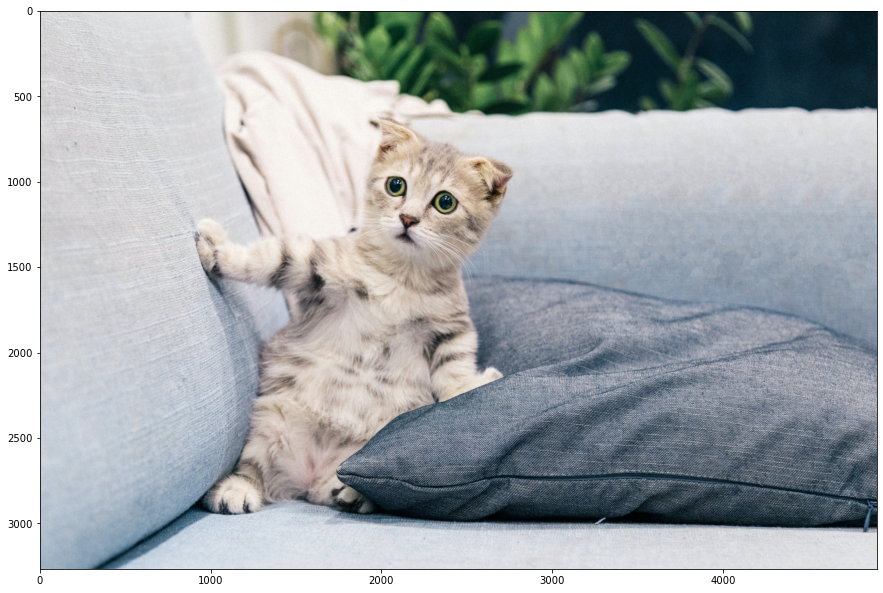

In [17]:
# Generate a random 256-bit key.
#key = os.urandom(32)
# Generate a random 96-bit IV.
iv = os.urandom(12)

textFileName = "content/message.txt"
restoredFileName = "content/restored_AES.txt"
imageFileName = 'content/cat.jpg'

print("encryption process")
key = "mhujtvghrvfdresghimkolojuybxgdfr"
key = key.encode("utf-8")
encryptedImgPath = AES_encrypt_and_encode(imageFileName, textFileName, key, iv)

print("decryption process")
origianMessage = AES_decode_and_decrypt(encryptedImgPath, restoredFileName, key, iv)

# Testing AES with image steganography

Maximum bytes to encode: 6000047
0101000101011100011110010111011101111100000010101000011101100100100100011101110011000100000111011010011000011001101000011111000010100101101110001011111101001010100110010110011111000111000101110001110010001110011011011001110111010010110010111101000101001111010111100011101111101111110111011100110110010100101010111101110001001011100101001000000010000111010100111011001110011111010111001001011000000001110001011110111100000000110010101010110101001011001111011010010110001110101111011100000011111111011110000001110100010101100001010010010010000011110001101000110011111000110010100111000100010010101100010010101100111000100101110110011011111000001001001101110000111000111000010100110000101111111101110101011101110010011010101001110100010000111001010000000010010101010100000001011001001000110100000111001110110110011010011000000010100011011111111110000000101011111011001010111011001100011101010110010000001110000101010101111111100111101001101001111011101101010110101101101

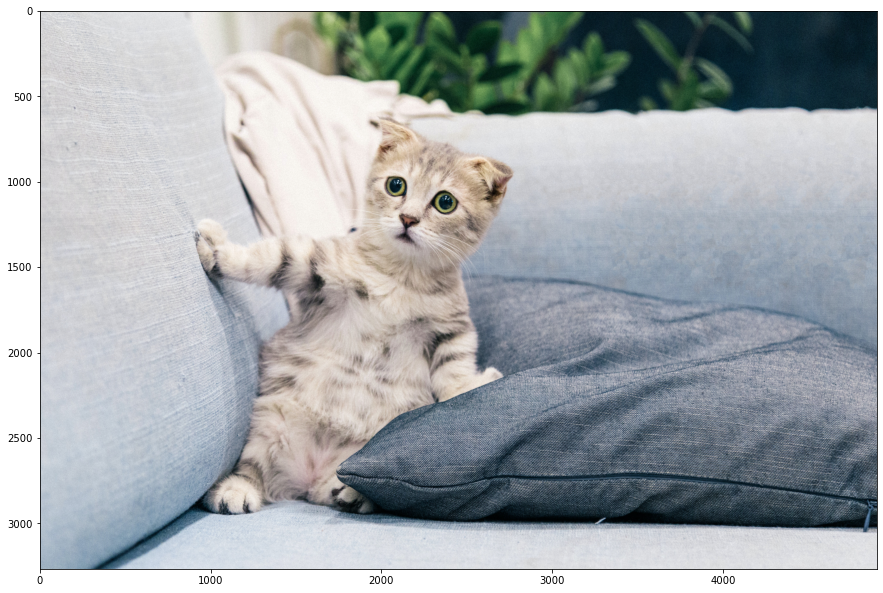

In [18]:
private_key = Create_private_key()
public_key = Create_public_key(private_key)

textFileName = "content/message.txt"
restoredFileName = "content/restored_RSA.txt"
imageFileName = 'content/cat.jpg'

encryptedImgPath = RSA_encrypt_and_encode(imageFileName, textFileName, public_key)

origianMessage = RSA_decode_and_decrypt(encryptedImgPath, restoredFileName, private_key)

In [48]:
#Import tkinter library
from tkinter import *
from tkinter.filedialog import askopenfilename 
from tkinter import scrolledtext


window_width,window_height = 600,400


def upload_original_image_file():
    filename = askopenfilename()
    global ImagePath_text
    ImagePath_text=Text(AES_encrpt_input,width=50,height=3)
    ImagePath_text.place(x = 180 , y = 80)
    ImagePath_text.insert(END, filename)
    global imageFileName
    imageFileName = ImagePath_text.get("1.0","end")
    
    
def upload_message_file():
    filename = askopenfilename()
    global messagePath_text
    messagePath_text=Text(AES_encrpt_input,width=50,height=3)
    messagePath_text.place(x = 180 , y = 150)
    messagePath_text.insert(END, filename)
    global textFileName
    textFileName = messagePath_text.get("1.0","end")
    
def upload_restored_file():
    filename = askopenfilename()
    text = Text(AES_decrypt_input,width=50,height=3)
    text.place(x = 180 , y = 150)
    text.insert(INSERT, filename)
    global  filePath
    filePath=text.get("1.0","end")
    
def Get_encrypt_key():
    global key
    key = key_text.get("1.0","end")
    
def Get_decrypt_key():
    global decrypted_key
    decrypted_key = key_decrypt_text.get("1.0","end")  
    
def Get_encrypt_ImagePath():
    filename = askopenfilename()
    text = Text(AES_decrypt_input,width=50,height=3)
    text.place(x = 180 , y = 80)
    text.insert(INSERT, filename)
    global encrypted_ImagePath
    encrypted_ImagePath = text.get("1.0","end")  
    


def Home_screen() :
    global Home
    Home= Tk()
    #Set the geometry of tkinter frame
    screen_width = Home.winfo_screenwidth()
    screen_height = Home.winfo_screenheight()
    
    position_top = int(screen_height/2 - window_height/2)
    position_right = int(screen_width/2 - window_width/2)
    
    Home.geometry(f'{window_width}x{window_height}+{position_right}+{position_top}')
    Label(Home, text="Select Cryptography Algorithms", font=('Century 20 bold')).place(x = 80 , y = 80)
    #Create a Label and a Button widget
    btn1=Button(Home, text="AES", width=15, height=2 ,font=10,bg=("#F98181"), 
                fg=('white'),command=en_de).place(x = 120 , y = 200)
    btn2=Button(Home, text="RSA", width=15, height=2 ,font=10,bg=("#F98181"), 
                fg=('white'),command=en_de).place(x = 310 , y = 200)
    Home.mainloop()

#-----------------------------------------------------------------------------------------------------

def en_de():
    Home.destroy()
    global win1
    win1 =Tk()
    
    screen_width = win1.winfo_screenwidth()
    screen_height = win1.winfo_screenheight()
    
    position_top = int(screen_height/2 - window_height/2)
    position_right = int(screen_width/2 - window_width/2)
    
    win1.geometry(f'{window_width}x{window_height}+{position_right}+{position_top}')
    
    L1 =Label (win1, text='Encrypt  or  Decrypt',font=(60))
    L1.pack(pady=100)   
    B1 = Button (win1, text='Encrypt', width=15, height=2, font=10, bg="pink",
                command=AES_encrpt_input_screen).place(x=100,y=215)
    B2 = Button (win1, text='Decrypt', width=15, height=2, font=10, bg="pink",
                 command=AES_decrypt_input_screen).place(x=350,y=215)
    win1.mainloop()

#------------------------------------------------------------------------------------------------------------

def AES_encrpt_input_screen() :
    win1.destroy()
    global AES_encrpt_input
    AES_encrpt_input = Tk()
    
    screen_width = AES_encrpt_input.winfo_screenwidth()
    screen_height = AES_encrpt_input.winfo_screenheight()
    
    position_top = int(screen_height/2 - window_height/2)
    position_right = int(screen_width/2 - window_width/2)
    
    AES_encrpt_input.geometry(f'{window_width}x{window_height}+{position_right}+{position_top}')
    
    Label(AES_encrpt_input, text="AES encrpt input",width=15,height=2, 
          font=('content/entury 20 bold',15)).place(x = 200 , y = 20)
    
    # Image Path
    Label(AES_encrpt_input, text="Image Path",width=15,height=2, 
          font=('content/entury 20 bold',12)).place(x = 10 , y = 80)
    text = Text(AES_encrpt_input,width=50,height=3).place(x = 180 , y = 80)
    image_path_button = Button(AES_encrpt_input, text="...", width=2,height=2 ,
                                font=('Century 20 bold',5),bg=('lightgray'), 
                                fg=('black'),command=upload_original_image_file).place(x = 150 , y = 90)
    
    # message file Path
    Label(AES_encrpt_input, text="message file path",width=15,height=2, 
          font=('content/entury 20 bold',12)).place(x = 10 , y =150)
    global messagePath_text
    messagePath_text = Text(AES_encrpt_input,width=50,height=3).place(x = 180 , y = 150)
    message_path_button = Button(AES_encrpt_input, text="...", width=2,height=2 ,
                                font=('Century 20 bold',5),bg=('lightgray'), 
                                fg=('black'),command=upload_message_file).place(x = 150 , y = 160)
    
    # Key
    Label(AES_encrpt_input, text="key",width=15,height=2, 
          font=('content/entury 20 bold',12)).place(x = 10 , y =220)
    global key_text
    key_text= Text(AES_encrpt_input,width=50,height=3)
    key_text.place(x = 180 , y = 220)
    message_path_button = Button(AES_encrpt_input, text="Save", width=3,height=2 ,
                                font=('Century 20 bold',5),bg=('lightgray'), 
                                fg=('black'),command=Get_encrypt_key).place(x = 150 , y = 220)
    
    
    
    # Next Button
    btn2=Button(AES_encrpt_input, text="Next", width=8,height=2 ,font=('Century 20 bold',20),bg=('pink'), 
            fg=('white'),command=AES_encrpt_output_screen).place(x = 230 , y = 290)
    
    AES_encrpt_input.mainloop()
    
#---------------------------------------------------------------------------------------------------------------
def destroy_AES_encrpt_output_screen():
    AES_encrpt_output.destroy()
    Home_screen()
    
    
#----------------------------------------------------------------------------------------------------------------

def destroy_AES_decrpt_output_screen():
    AES_decrypt_ouput.destroy()
    Home_screen()
    
#----------------------------------------------------------------------------------------------------------------

def AES_encrpt_output_screen() :
    AES_encrpt_input.destroy()
    global AES_encrpt_output
    AES_encrpt_output= Tk()
    
    screen_width = AES_encrpt_output.winfo_screenwidth()
    screen_height = AES_encrpt_output.winfo_screenheight()
    
    position_top = int(screen_height/2 - window_height/2)
    position_right = int(screen_width/2 - window_width/2)
    
    AES_encrpt_output.geometry(f'{window_width}x{window_height}+{position_right}+{position_top}')
    
    # call AES Encrypt
    iv="mayarhanafy11111"
    iv= iv.encode("utf-8")
    key_test = key.encode("utf-8")
    encryptedImgPath = AES_encrypt_and_encode(imageFileName[:-1], textFileName[:-1], key_test[:-1], iv)
    
    print(encryptedImgPath)
    
    Label(AES_encrpt_output, text="AES encrpt output",width=15,height=2, 
          font=('content/entury 20 bold',15)).place(x = 200 , y = 20)
    
    # Encrypted Image Path
    Label(AES_encrpt_output, text="Encrypted Image Path",width=30,height=2, 
          font=('content/entury 20 bold',12)).place(x = 30 , y = 80)
    global Encrpted_Image_path
    Encrpted_Image_path = Text(AES_encrpt_output,width=50,height=3)
    Encrpted_Image_path.place(x = 50 , y = 150)
    Encrpted_Image_path.insert(END, encryptedImgPath)
    
    # Home Button
    btn2=Button(AES_encrpt_output, text="Home", width=8,height=2 ,font=('Century 20 bold',20),bg=('pink'), 
            fg=('white'),command=destroy_AES_encrpt_output_screen).place(x = 230 , y = 290)
    
    AES_encrpt_output.mainloop()
    
#--------------------------------------------------------------------------------------------------------------

def AES_decrypt_input_screen():
    win1.destroy()
    global AES_decrypt_input
    AES_decrypt_input = Tk()
    
    screen_width = AES_decrypt_input.winfo_screenwidth()
    screen_height = AES_decrypt_input.winfo_screenheight()
    
    position_top = int(screen_height/2 - window_height/2)
    position_right = int(screen_width/2 - window_width/2)
    
    AES_decrypt_input.geometry(f'{window_width}x{window_height}+{position_right}+{position_top}')
    
    Label(AES_decrypt_input, text='AES Decrypt Input',width=15,height=2, 
          font=('content/entury 20 bold',15)).place(x = 200 , y = 20)
    
    # Encrypt Image Path
    Label(AES_decrypt_input, text='Encrypted image path',width=15,height=2, 
          font=('content/entury 20 bold',10)).place(x = 10 , y = 80)
    text = Text(AES_decrypt_input,width=50,height=3).place(x = 180 , y = 80)
    image_path_button = Button(AES_decrypt_input, text="...", width=2,height=2 ,
                                font=('Century 20 bold',5),bg=('lightgray'), 
                                fg=('black'),command=Get_encrypt_ImagePath).place(x = 150 , y = 90)
    
    # Restored file Path
    Label(AES_decrypt_input, text='Restored file path',width=15,height=2, 
          font=('content/entury 20 bold',10)).place(x = 10 , y =150)
    text = Text(AES_decrypt_input,width=50,height=3).place(x = 180 , y = 150)
    message_path_button = Button(AES_decrypt_input, text="...", width=2,height=2 ,
                                font=('Century 20 bold',5),bg=('lightgray'), 
                                fg=('black'),command=upload_restored_file).place(x = 150 , y = 160)
    
    # Key
    Label(AES_decrypt_input, text='Key',width=15,height=2, 
          font=('content/entury 20 bold',10)).place(x = 10 , y =220)
    global key_decrypt_text
    key_decrypt_text= Text(AES_decrypt_input,width=50,height=3)
    key_decrypt_text.place(x = 180 , y = 220)
    message_path_button = Button(AES_decrypt_input, text="Save", width=3,height=2 ,
                                font=('Century 20 bold',5),bg=('lightgray'), 
                                fg=('black'),command=Get_decrypt_key).place(x = 150 , y = 220)
    
    
    # Next Button
    btn2=Button(AES_decrypt_input, text="Next", width=8,height=2 ,font=('Century 20 bold',20),bg=('pink'), 
            fg=('white'),command=AES_decrypt_ouput_screen).place(x = 230 , y = 290)
    
    AES_decrypt_input.mainloop()
    
    
#-------------------------------------------------------------------------------------------------------------

def AES_decrypt_ouput_screen():
    AES_decrypt_input.destroy()
    global AES_decrypt_ouput
    AES_decrypt_ouput =Tk()
    
    screen_width = AES_decrypt_ouput.winfo_screenwidth()
    screen_height = AES_decrypt_ouput.winfo_screenheight()
    
    position_top = int(screen_height/2 - window_height/2)
    position_right = int(screen_width/2 - window_width/2)
    
    AES_decrypt_ouput.geometry(f'{window_width}x{window_height}+{position_right}+{position_top}')
    
    L=Label (AES_decrypt_ouput, text='AES Decrypt Output',font=(60))
    L.pack(pady=40)
    Message=Label(AES_decrypt_ouput, text='Message',font=(60)).place(x=20,y=100)
    
    # call AES Decrypt
    iv="mayarhanafy11111"
    iv= iv.encode("utf-8")
    key_dec = decrypted_key.encode("utf-8")
    origianMessage = AES_decode_and_decrypt(encrypted_ImagePath[:-1], filePath[:-1], key_dec[:-1], iv)
    print( origianMessage)
    #output = Text(win3,width=50,height=9).place(x=70,y=150)
    original_Message_text = scrolledtext.ScrolledText(AES_decrypt_ouput,wrap=WORD,width=60,height=9)
    original_Message_text.place(x=70,y=140) 
    original_Message_text.insert(INSERT, origianMessage)
    
    
    # Home Button
    btn2=Button(AES_decrypt_ouput, text="Home", width=8,height=2 ,font=('Century 20 bold',20),bg=('pink'), 
            fg=('white'),command=destroy_AES_decrpt_output_screen).place(x = 230 , y = 290)

#-----------------------------------------------------------------------------------------------------------

    
Home_screen()